In [33]:
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
# Dati estrapolati dal db remoto di Giuliano in data 19/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

df = pd.concat([df1, df2], ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


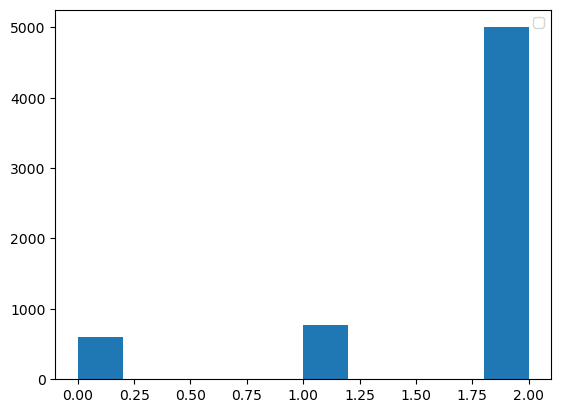

In [51]:
plt.hist([df['ae_cl']])
plt.legend()
plt.show()

In [54]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin

In [55]:
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = df['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
df = pd.concat([df, split_series], axis=1)

# Rename the split columns
df.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

df['mn'] = df.select_dtypes(include='number').mean(axis=1)
df['ds'] = df.select_dtypes(include='number').std(axis=1)

# Drop the original 'rv' column
df.drop('rv', axis=1, inplace=True)

df.head()

,tm,knt,ae,ae_cl,rv1,rv2,rv3,rv4,rv5,rv6,...,rv1493,rv1494,rv1495,rv1496,rv1497,rv1498,rv1499,rv1500,mn,ds
0,2024-01-18 12:11:01.088401,1500,0.317388,0,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,...,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005,500.105796,707.031984
1,2023-08-25 14:09:16.8856,1500,0.249031,0,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,...,2.0002,2.0002,2.0002,2.0002,1.0001,2.0002,2.0002,2.0002,500.083010,707.048091
2,2023-08-25 15:01:45.379524,1500,0.181943,0,2.0002,2.0002,1.0001,2.0002,2.0002,1.0001,...,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,500.060648,707.063901
3,2023-08-30 18:48:30.942519,1500,0.146769,0,2.0002,2.0002,2.0002,2.0002,1.0001,2.0002,...,2.0002,2.0002,1.0001,2.0002,2.0002,2.0002,2.0002,2.0002,500.048923,707.072190
4,2023-08-30 20:05:41.072751,1500,0.109208,0,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,...,1.0001,1.0001,2.0002,2.0002,1.0001,2.0002,2.0002,1.0001,500.036403,707.081042


In [57]:
X = df.loc[:, 'rv1':'ds'].astype(float).values
y = df['ae_cl']

In [59]:
# Preprocessing steps
# Impute missing values (if any)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [60]:
# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [61]:

# Define a KerasRegressor wrapper
class MLPRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layer_size=100, epochs=50, batch_size=32):
        self.hidden_layer_size = hidden_layer_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(self.hidden_layer_size, activation='relu', input_shape=(X_train.shape[1],)),
            tf.keras.layers.Dense(1)  # Output layer for regression
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

In [63]:
# Create a pipeline with preprocessing and the MLPRegressorWrapper
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressorWrapper())
])

In [65]:
# Define the parameter grid to search
param_grid = {
    'mlp__hidden_layer_size': [50, 100, 150],
    'mlp__epochs': [50, 100],
    'mlp__batch_size': [32, 64]
}


In [66]:
# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('mlp', MLPRegressorWrapper())]),
             n_jobs=-1,
             param_grid={'mlp__batch_size': [32, 64], 'mlp__epochs': [50, 100],
                         'mlp__hidden_layer_size': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [67]:
# Get the best parameters
best_params = grid_search.best_params_

In [69]:
# Make predictions on the test set
predictions = grid_search.predict(X_test)

40/40 [==============================] - 0s 795us/step


In [70]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Best parameters: {best_params}")
print(f"Root Mean Squared Error on the test set: {rmse}")
print(f"R-squared on the test set: {r2}")

Best parameters: {'mlp__batch_size': 64, 'mlp__epochs': 100, 'mlp__hidden_layer_size': 50}
Root Mean Squared Error on the test set: 0.08122997971828243
R-squared on the test set: 0.9854912498083588


In [77]:
predictionsRound = np.around(predictions, decimals=0)

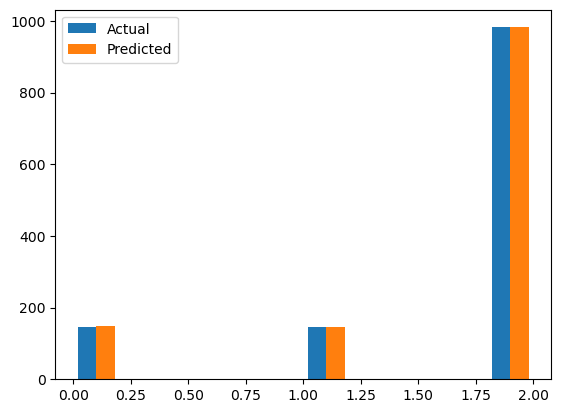

In [78]:
plt.hist([y_test, predictionsRound], label=['Actual', 'Predicted'])
plt.legend()
plt.show()